In [29]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [0]:
from keras import backend as K
K.clear_session()

In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [34]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def yoon_kim_conv_layer(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)
    block_1_avg_pool1 = GlobalAveragePooling1D()(block_1_batchnorm1)
    
    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)
    block_1_avg_pool2 = GlobalAveragePooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)
    block_1_avg_pool3 = GlobalAveragePooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)
    block_1_avg_pool4 = GlobalAveragePooling1D()(block_1_batchnorm4)
    
    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4,
        block_1_avg_pool1, 
        block_1_avg_pool2, 
        block_1_avg_pool3, 
        block_1_avg_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [37]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 256

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features = yoon_kim_conv_layer(filtersNumber, embedding_dropout)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [14]:
history = train_with_cv(model, batchSize=64, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 42880/102124 [===========>..................] - ETA: 1:55 - loss: 0.1595 - acc: 0.9389

102124/102124 [==============================] - 213s 2ms/step - loss: 0.1021 - acc: 0.9618 - val_loss: 0.0485 - val_acc: 0.9823
Epoch 2/32
  5568/102124 [>.............................] - ETA: 3:04 - loss: 0.0568 - acc: 0.9795

102080/102124 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9807

102124/102124 [==============================] - 209s 2ms/step - loss: 0.0522 - acc: 0.9808 - val_loss: 0.0449 - val_acc: 0.9831
roc-auc: 0.9873 - roc-auc_val: 0.9835                                                                                                    
Epoch 3/32
 17472/102124 [====>.........................] - ETA: 2:39 - loss: 0.0488 - acc: 0.9817

102080/102124 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9818

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0478 - acc: 0.9819 - val_loss: 0.0420 - val_acc: 0.9839
Epoch 4/32
 28096/102124 [=======>......................] - ETA: 2:20 - loss: 0.0440 - acc: 0.9829

102080/102124 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9828

102124/102124 [==============================] - 209s 2ms/step - loss: 0.0447 - acc: 0.9828 - val_loss: 0.0430 - val_acc: 0.9836
roc-auc: 0.9919 - roc-auc_val: 0.9865                                                                                                    
Epoch 5/32
 17472/102124 [====>.........................] - ETA: 2:39 - loss: 0.0441 - acc: 0.9823

102080/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9834

102124/102124 [==============================] - 209s 2ms/step - loss: 0.0425 - acc: 0.9834 - val_loss: 0.0470 - val_acc: 0.9841

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
 16128/102124 [===>..........................] - ETA: 2:42 - loss: 0.0390 - acc: 0.9845

102080/102124 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9842

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0400 - acc: 0.9842 - val_loss: 0.0411 - val_acc: 0.9846
roc-auc: 0.9938 - roc-auc_val: 0.9872                                                                                                    
Epoch 7/32
 17472/102124 [====>.........................] - ETA: 2:40 - loss: 0.0382 - acc: 0.9849

102080/102124 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9849

102124/102124 [==============================] - 211s 2ms/step - loss: 0.0376 - acc: 0.9849 - val_loss: 0.0429 - val_acc: 0.9839
Epoch 8/32
 28096/102124 [=======>......................] - ETA: 2:22 - loss: 0.0354 - acc: 0.9858

102080/102124 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9856

102124/102124 [==============================] - 211s 2ms/step - loss: 0.0361 - acc: 0.9856 - val_loss: 0.0447 - val_acc: 0.9830
roc-auc: 0.995 - roc-auc_val: 0.9861                                                                                                    
Epoch 9/32
 17536/102124 [====>.........................] - ETA: 2:39 - loss: 0.0344 - acc: 0.9862

102080/102124 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9863

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0342 - acc: 0.9863 - val_loss: 0.0437 - val_acc: 0.9841
Epoch 10/32
 20288/102124 [====>.........................] - ETA: 2:34 - loss: 0.0320 - acc: 0.9869

102080/102124 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9868

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0327 - acc: 0.9868 - val_loss: 0.0431 - val_acc: 0.9843
roc-auc: 0.9953 - roc-auc_val: 0.9865                                                                                                    
Epoch 11/32
 17408/102124 [====>.........................] - ETA: 2:40 - loss: 0.0309 - acc: 0.9872

102080/102124 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9873

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0312 - acc: 0.9873 - val_loss: 0.0441 - val_acc: 0.9832
Epoch 12/32
 20288/102124 [====>.........................] - ETA: 2:34 - loss: 0.0298 - acc: 0.9879

102080/102124 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9879

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0299 - acc: 0.9879 - val_loss: 0.0447 - val_acc: 0.9842
roc-auc: 0.9974 - roc-auc_val: 0.986                                                                                                    
Epoch 13/32
 17472/102124 [====>.........................] - ETA: 2:40 - loss: 0.0290 - acc: 0.9882

102080/102124 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9881

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0288 - acc: 0.9881 - val_loss: 0.0487 - val_acc: 0.9840
Epoch 14/32
 20288/102124 [====>.........................] - ETA: 2:34 - loss: 0.0273 - acc: 0.9888

102080/102124 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9887

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0279 - acc: 0.9887 - val_loss: 0.0474 - val_acc: 0.9839
roc-auc: 0.9976 - roc-auc_val: 0.9862                                                                                                    
Epoch 15/32
 17408/102124 [====>.........................] - ETA: 2:39 - loss: 0.0260 - acc: 0.9895

102080/102124 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9892

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0263 - acc: 0.9892 - val_loss: 0.0476 - val_acc: 0.9840
Epoch 16/32
 20288/102124 [====>.........................] - ETA: 2:34 - loss: 0.0243 - acc: 0.9900

102080/102124 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9895

102124/102124 [==============================] - 210s 2ms/step - loss: 0.0256 - acc: 0.9895 - val_loss: 0.0490 - val_acc: 0.9840

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00010511204891372472.
roc-auc: 0.9933 - roc-auc_val: 0.9826                                                                                                    


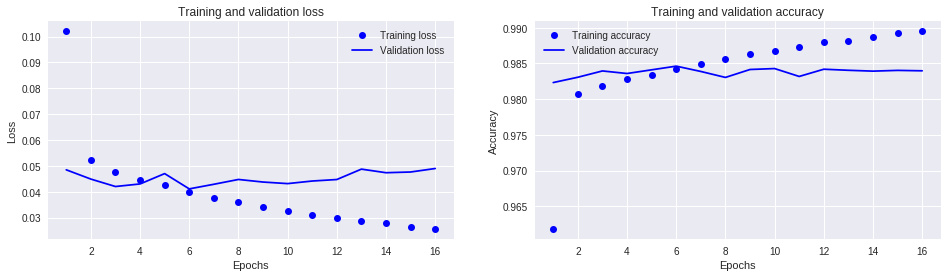

In [15]:
plot_history(history)

In [16]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 26s 810us/step
([0.04568297758586626, 0.9846414817643916], 0.9834124819077118)


In [26]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21440/102124 [=====>........................] - ETA: 3:09 - loss: 0.1706 - acc: 0.9353

102112/102124 [============================>.] - ETA: 0s - loss: 0.0832 - acc: 0.9695

102124/102124 [==============================] - 252s 2ms/step - loss: 0.0832 - acc: 0.9695 - val_loss: 0.0456 - val_acc: 0.9834
Epoch 2/32
 14048/102124 [===>..........................] - ETA: 3:18 - loss: 0.0518 - acc: 0.9814

102112/102124 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9810

102124/102124 [==============================] - 250s 2ms/step - loss: 0.0515 - acc: 0.9810 - val_loss: 0.0437 - val_acc: 0.9834
roc-auc: 0.9887 - roc-auc_val: 0.9857                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 3:31 - loss: 0.0502 - acc: 0.9813

102112/102124 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9819

102124/102124 [==============================] - 252s 2ms/step - loss: 0.0473 - acc: 0.9819 - val_loss: 0.0429 - val_acc: 0.9841
Epoch 4/32
 10176/102124 [=>............................] - ETA: 3:31 - loss: 0.0451 - acc: 0.9824

102112/102124 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9830

102124/102124 [==============================] - 254s 2ms/step - loss: 0.0443 - acc: 0.9830 - val_loss: 0.0440 - val_acc: 0.9838
roc-auc: 0.9902 - roc-auc_val: 0.9855                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 3:33 - loss: 0.0423 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9838

102124/102124 [==============================] - 249s 2ms/step - loss: 0.0414 - acc: 0.9838 - val_loss: 0.0424 - val_acc: 0.9842
Epoch 6/32
 10176/102124 [=>............................] - ETA: 3:27 - loss: 0.0381 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9843

102124/102124 [==============================] - 249s 2ms/step - loss: 0.0394 - acc: 0.9843 - val_loss: 0.0444 - val_acc: 0.9839
roc-auc: 0.9898 - roc-auc_val: 0.9825                                                                                                    
Epoch 7/32
  8736/102124 [=>............................] - ETA: 3:33 - loss: 0.0348 - acc: 0.9863

102112/102124 [============================>.] - ETA: 0s - loss: 0.0367 - acc: 0.9854

102124/102124 [==============================] - 250s 2ms/step - loss: 0.0367 - acc: 0.9854 - val_loss: 0.0420 - val_acc: 0.9844
Epoch 8/32
 10176/102124 [=>............................] - ETA: 3:28 - loss: 0.0331 - acc: 0.9869

102112/102124 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9859

102124/102124 [==============================] - 250s 2ms/step - loss: 0.0351 - acc: 0.9859 - val_loss: 0.0440 - val_acc: 0.9842
roc-auc: 0.9931 - roc-auc_val: 0.9839                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 3:31 - loss: 0.0346 - acc: 0.9863

102112/102124 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9863

102124/102124 [==============================] - 249s 2ms/step - loss: 0.0336 - acc: 0.9863 - val_loss: 0.0445 - val_acc: 0.9838

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00021763764380011708.
Epoch 10/32
  8032/102124 [=>............................] - ETA: 3:33 - loss: 0.0314 - acc: 0.9876

102112/102124 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9870

102124/102124 [==============================] - 250s 2ms/step - loss: 0.0317 - acc: 0.9870 - val_loss: 0.0452 - val_acc: 0.9839
roc-auc: 0.9958 - roc-auc_val: 0.9841                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 3:33 - loss: 0.0301 - acc: 0.9880

102112/102124 [============================>.] - ETA: 0s - loss: 0.0304 - acc: 0.9875

102124/102124 [==============================] - 252s 2ms/step - loss: 0.0304 - acc: 0.9875 - val_loss: 0.0479 - val_acc: 0.9839
Epoch 12/32
 10144/102124 [=>............................] - ETA: 3:27 - loss: 0.0283 - acc: 0.9888

102112/102124 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9880

102124/102124 [==============================] - 250s 2ms/step - loss: 0.0292 - acc: 0.9880 - val_loss: 0.0514 - val_acc: 0.9840
roc-auc: 0.9915 - roc-auc_val: 0.9803                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 3:30 - loss: 0.0272 - acc: 0.9888

102112/102124 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9885

102124/102124 [==============================] - 249s 2ms/step - loss: 0.0281 - acc: 0.9885 - val_loss: 0.0470 - val_acc: 0.9834
Epoch 14/32
 10144/102124 [=>............................] - ETA: 3:27 - loss: 0.0259 - acc: 0.9893

102112/102124 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9888

102124/102124 [==============================] - 249s 2ms/step - loss: 0.0271 - acc: 0.9888 - val_loss: 0.0497 - val_acc: 0.9840
roc-auc: 0.9933 - roc-auc_val: 0.982                                                                                                    
Epoch 15/32
  8736/102124 [=>............................] - ETA: 3:33 - loss: 0.0244 - acc: 0.9900

102112/102124 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9892

102124/102124 [==============================] - 252s 2ms/step - loss: 0.0262 - acc: 0.9892 - val_loss: 0.0520 - val_acc: 0.9836
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 3:21 - loss: 0.0263 - acc: 0.9891

102112/102124 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9896

102124/102124 [==============================] - 253s 2ms/step - loss: 0.0255 - acc: 0.9896 - val_loss: 0.0524 - val_acc: 0.9840
roc-auc: 0.9926 - roc-auc_val: 0.9809                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 3:32 - loss: 0.0238 - acc: 0.9906

102112/102124 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9899

102124/102124 [==============================] - 250s 2ms/step - loss: 0.0248 - acc: 0.9899 - val_loss: 0.0551 - val_acc: 0.9834


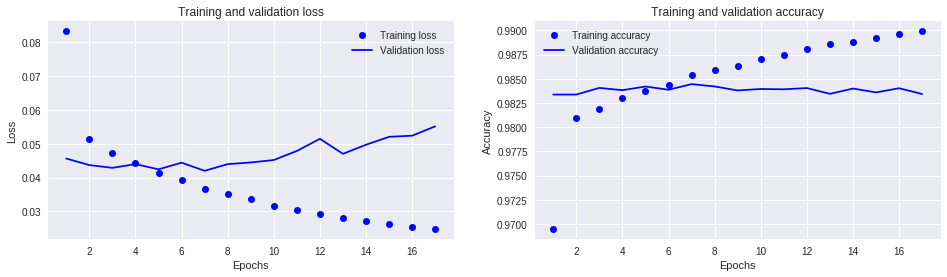

In [27]:
plot_history(history)

In [28]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 25s 790us/step
([0.05103764745457728, 0.9842289279867971], 0.9807558155003733)


In [38]:
history = train_with_cv(model, batchSize=128, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 85888/102124 [========================>.....] - ETA: 28s - loss: 0.1485 - acc: 0.9450

102124/102124 [==============================] - 193s 2ms/step - loss: 0.1346 - acc: 0.9503 - val_loss: 0.0559 - val_acc: 0.9810
Epoch 2/32
 50048/102124 [=============>................] - ETA: 1:28 - loss: 0.0550 - acc: 0.9803

102124/102124 [==============================] - 190s 2ms/step - loss: 0.0541 - acc: 0.9804 - val_loss: 0.0482 - val_acc: 0.9822
roc-auc: 0.9859 - roc-auc_val: 0.9822                                                                                                    
Epoch 3/32
 22528/102124 [=====>........................] - ETA: 2:16 - loss: 0.0527 - acc: 0.9808

102124/102124 [==============================] - 190s 2ms/step - loss: 0.0494 - acc: 0.9815 - val_loss: 0.0424 - val_acc: 0.9841
Epoch 4/32
 25856/102124 [======>.......................] - ETA: 2:10 - loss: 0.0466 - acc: 0.9821

102124/102124 [==============================] - 190s 2ms/step - loss: 0.0467 - acc: 0.9822 - val_loss: 0.0425 - val_acc: 0.9839
roc-auc: 0.9902 - roc-auc_val: 0.9858                                                                                                    
Epoch 5/32
 16768/102124 [===>..........................] - ETA: 2:25 - loss: 0.0449 - acc: 0.9824

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0437 - acc: 0.9831 - val_loss: 0.0411 - val_acc: 0.9843
Epoch 6/32
 23680/102124 [=====>........................] - ETA: 2:14 - loss: 0.0417 - acc: 0.9837

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0417 - acc: 0.9838 - val_loss: 0.0418 - val_acc: 0.9844
roc-auc: 0.993 - roc-auc_val: 0.9869                                                                                                    
Epoch 7/32
 16256/102124 [===>..........................] - ETA: 2:27 - loss: 0.0383 - acc: 0.9851

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0396 - acc: 0.9845 - val_loss: 0.0438 - val_acc: 0.9836

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002679433673620224.
Epoch 8/32
 17280/102124 [====>.........................] - ETA: 2:25 - loss: 0.0384 - acc: 0.9843

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0381 - acc: 0.9849 - val_loss: 0.0420 - val_acc: 0.9844
roc-auc: 0.9946 - roc-auc_val: 0.9875                                                                                                    
Epoch 9/32
 14720/102124 [===>..........................] - ETA: 2:29 - loss: 0.0354 - acc: 0.9857

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0359 - acc: 0.9857 - val_loss: 0.0480 - val_acc: 0.9840
Epoch 10/32
 22784/102124 [=====>........................] - ETA: 2:15 - loss: 0.0338 - acc: 0.9866

102124/102124 [==============================] - 190s 2ms/step - loss: 0.0345 - acc: 0.9861 - val_loss: 0.0427 - val_acc: 0.9843
roc-auc: 0.9952 - roc-auc_val: 0.9863                                                                                                    
Epoch 11/32
 16000/102124 [===>..........................] - ETA: 2:27 - loss: 0.0334 - acc: 0.9867

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0334 - acc: 0.9868 - val_loss: 0.0437 - val_acc: 0.9837
Epoch 12/32
 23168/102124 [=====>........................] - ETA: 2:15 - loss: 0.0306 - acc: 0.9877

102124/102124 [==============================] - 190s 2ms/step - loss: 0.0317 - acc: 0.9873 - val_loss: 0.0440 - val_acc: 0.9844
roc-auc: 0.997 - roc-auc_val: 0.9866                                                                                                    
Epoch 13/32
 16128/102124 [===>..........................] - ETA: 2:27 - loss: 0.0300 - acc: 0.9880

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0306 - acc: 0.9877 - val_loss: 0.0446 - val_acc: 0.9840
Epoch 14/32
 23296/102124 [=====>........................] - ETA: 2:14 - loss: 0.0283 - acc: 0.9886

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0294 - acc: 0.9881 - val_loss: 0.0444 - val_acc: 0.9836
roc-auc: 0.9963 - roc-auc_val: 0.9839                                                                                                    
Epoch 15/32
 16128/102124 [===>..........................] - ETA: 2:27 - loss: 0.0272 - acc: 0.9891

102124/102124 [==============================] - 191s 2ms/step - loss: 0.0285 - acc: 0.9885 - val_loss: 0.0456 - val_acc: 0.9839


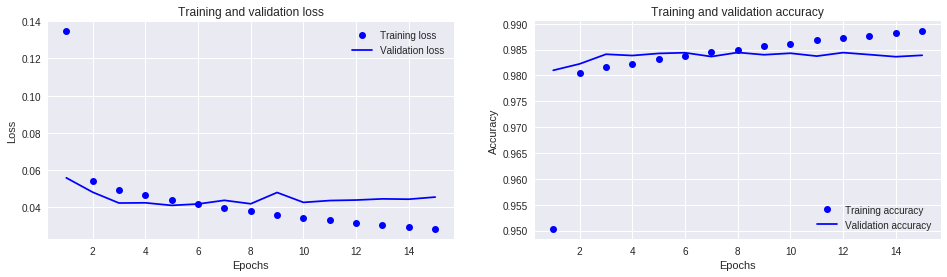

In [39]:
plot_history(history)

In [40]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 25s 796us/step
([0.043150325208104544, 0.9841871494020243], 0.98797149470583)
